In [4]:
!pip install transformers

In [5]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
from nltk.corpus import wordnet
import random
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [7]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Function Definitions

In [8]:
#Generator Function for Non-Numeric Words
#X is a pandas Series of a sentence
#here gamma is the number of iterations
#returns a series of modified messages (might be modified)
def generatorWords(X,gamma):

  fakeX = []

  if len(X.unique()) < len(X)/2: #if the number of unique values is less than half of the set
    uniqueVals = X.unique()
    fakeX = []
    for i in range(len(X)):
      fakeX.append(random.choice(uniqueVals))
  else:
    for index, value in X.items():
      words = value.split(" ")
      adjs = []
      choosenWord = ""
      pos_all = dict()
      antonyms = []

      #priortize adjectives
      for w in words:
        #print(w)
        pos_l = set()
        for tmp in wn.synsets(w):
            if tmp.name().split('.')[0] == w:
                pos_l.add(tmp.pos())
        pos_all[w] = pos_l

      #in the list of word classes we single out the adjectives
      for a in pos_all:
        if "a" in pos_all[a]:
          adjs.append(a)

      #here we choose which word to flip
      if adjs:
        choosenWord = adjs[0] if len(adjs) > 1 else adjs[0]
      else:
        choosenWord = words[0] if len(words) > 1 else words[0]

      #find antonyms of the choosen word
      for syn in wordnet.synsets(choosenWord):
        for lm in syn.lemmas():
            if lm.antonyms():
                antonyms.append(lm.antonyms()[0].name())
      if antonyms:
        new = [antonyms[gamma] if x==choosenWord else x for x in words]
      else:
        new = [x if x==choosenWord else x for x in words]
      fakeX.append(" ".join(new))
  return pd.Series(fakeX)


In [9]:
#Generator Function For Numeric Data Points
#X is a series of numbers
#gamma = 1.4
#intX = list(map(int, X)) #make sure X is an int
def generatorNum(X,gamma):
  xHat = np.mean(X)
  sx = np.std(X)
  randomUpper = (xHat) + (sx * gamma)
  randomLower = (xHat) - (sx * gamma)
  beta = []
  for i in range(int(len(X))):
      beta.append(random.randrange(int(randomLower),int(randomUpper)))
  beta = list(map(str, beta))
  #print(beta)
  return pd.Series(beta)

In [10]:
#Generator That Points Data Into The Right Generator
def generator(df,gamma):
  mDF = df.copy()
  mDF["temperature"] = generatorNum(df["temperature"],gamma)
  mDF["outlook"] = generatorWords(df["outlook"],0)
  mDF["wind"] = generatorWords(df["wind"],0)
  mDF["humidity"] = generatorNum(df["humidity"],gamma)
  fakeData = addLabel(makeSentence(mDF),1) #column 0 is sentences, column 1 is label
  realData = addLabel(makeSentence(df),0)  #Label 0 means data, label 1 means fake data
  return(pd.concat([fakeData,realData],axis=0),fakeData)

In [11]:
#Merges All DataFrame Columns Into A Single Sentence
#Returns a series of the merged DataFrame columns
def makeSentence(df):
  #df is a data frame
  df = df.copy().applymap(str)
  seriesA = df[df.columns[0:]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
  return seriesA

In [12]:
#Adds a label columns to series for classification
#Returns dataframe of two columns, the series and the labels
def addLabel(series,label):
  #takes in a pandas series and a label
  #returns a dataframe
  labels = []
  [labels.append(label) for i in range(len(series))]
  labels = pd.Series(labels)
  return pd.concat([series,labels],axis=1)

In [13]:
#Discriminiator for deteremining whether data is malicious or not
#Returns new gamma, other parameters are for testing and graphing purposes
def discriminator(X, gamma, rho):
  #takes in dataframe in BERT format of sentence and label
  #returns a new gamme to generate data with
  score,indexes,fn,total = BERT(X)
  print("score: " + str(score))
  #if 0.35 < score < 0.55:
  ##  return None
  #else:
  return (score,gamma + rho,indexes,fn,total)

In [14]:
def BERT(df):
  #df is a dataframe containing sentences and labels
  #BERT returns a accruacy and indexes of false negatives

  #tokenize
  tokenized = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) #pad
  attention_mask = np.where(padded != 0, 1, 0)                            #apply masks
  input_ids = torch.tensor(padded)
  attention_mask = torch.tensor(attention_mask)                           #put masks through torch tensor

  #run through bert
  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask)
  features = last_hidden_states[0][:,0,:].numpy()
  labels = df[1]
  return(regression(features,labels))

In [15]:
#Takes BERT pretrained output and put's it through logistic regression
#Returns accuracy and indexes of false negatives
def regression(features,labels):
  train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)
  #lr_clf = LogisticRegression(max_iter=500)
  #lr_clf.fit(train_features, train_labels)
  #return(lr_clf.score(test_features, test_labels))
  NeuralNetwork = MLPClassifier(solver='adam', activation="logistic", random_state=1,max_iter=5000)
  NeuralNetwork.fit(train_features, train_labels)
  y2 = NeuralNetwork.predict(test_features)
  y2 = pd.Series(NeuralNetwork.predict(test_features))
  #print(test_labels)
  i=0
  indexes = []
  for index, value in test_labels.items():
    if value == 1:
      if y2[i] == 0:
        indexes.append(index)
    i+=1
  #print(indexes)
  tn, fp, fn, tp = confusion_matrix(test_labels, y2).ravel()
  #fp = confusion_matrix(test_labels, y2)[0][1]
  total = len(test_labels)
  return (NeuralNetwork.score(test_features,test_labels),indexes,fn,total)

In [16]:
def indexToEntry(X,indexes):
  #finds list of indexes in X and returns a dataframe with the entries
  entries = []
  for i in indexes:
    entries.append(X.iloc[i])
  return(pd.DataFrame(entries))

In [17]:
def logisticRegression(train_features, test_features, train_labels, test_labels):
  lr_clf = LogisticRegression(max_iter=500)
  lr_clf.fit(train_features, train_labels)
  #print(lr_clf.score(test_features, test_labels))
  y_pred = lr_clf.predict(test_features)
  score = lr_clf.score(test_features, test_labels)
  tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
  return(fn,score)

In [18]:
def RandomForest(train_features, test_features, train_labels, test_labels):
  RandForest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
  RandForest.fit(train_features, train_labels)
  forest_pred = RandForest.predict(test_features)
  score = RandForest.score(test_features,test_labels)
  tn, fp, fn, tp = confusion_matrix(test_labels, forest_pred).ravel()
  return(fn,score)


In [19]:
def KNN(train_features, test_features, train_labels, test_labels):
  #K Nearest Neighbor With Optimal Neighbor (1)
  knn = KNeighborsClassifier(n_neighbors = 1)
  knn.fit(train_features,train_labels)
  score = knn.score(test_features, test_labels)
  y_pred = knn.predict(test_features)
  tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
  #print(confusion_matrix(test_labels, y_pred))
  #print(classification_report(y_test, y_pred))
  return(fn,score)

In [20]:
def MLP(train_features, test_features, train_labels, test_labels):
  NeuralNetwork = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
  NeuralNetwork.fit(train_features, train_labels)
  nn_pred = NeuralNetwork.predict(test_features)
  score = NeuralNetwork.score(test_features,test_labels)
  #print(confusion_matrix(test_labels, nn_pred))
  tn, fp, fn, tp = confusion_matrix(test_labels, nn_pred).ravel()
  return(fn,score)

In [21]:
def SVM(train_features, test_features, train_labels, test_labels):
  clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  clf.fit(train_features,train_labels)
  svmPred = clf.predict(test_features)
  score = clf.score(test_features,test_labels)
  #print(confusion_matrix(test_labels, pred))
  tn, fp, fn, tp = confusion_matrix(test_labels, svmPred).ravel()
  return(fn,score)

In [22]:
def tests(df,mDF):
  ogData = addLabel(makeSentence(df),0)
  testData = pd.concat([ogData,mDF])
  tokenized = testData[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  train_features, test_features, train_labels, test_labels = train_test_split(padded, testData[1], random_state=42)
  lrFN,lrScore = logisticRegression(train_features, test_features, train_labels, test_labels)
  rfFN,rfScore = RandomForest(train_features, test_features, train_labels, test_labels)
  knnFN,knnScore = KNN(train_features, test_features, train_labels, test_labels)
  mlpFN,mlpScore = MLP(train_features, test_features, train_labels, test_labels)
  svmFN,svmScore = SVM(train_features, test_features, train_labels, test_labels)
  #print("test_labels: " + str(len(test_labels)))
  return(lrFN,lrScore,rfFN,rfScore,knnFN,knnScore,mlpFN,mlpScore,svmFN,svmScore)

## Processing

In [23]:
df = pd.read_csv('https://raw.githubusercontent.com/HenryCWong/adversarialBERTMessages/master/weather_sample_data.csv', delimiter=',')

In [24]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [25]:
df.head()

,temperature,outlook,wind,humidity
0,40,cloudy,E,14
1,51,partly cloudy,SE,95
2,47,severe_thunderstorm,SE,88
3,45,thunderstorm,W,35
4,43,sunny,SE,33


## Actual Stuffs

In [26]:
X,mDF = generator(df,1)

/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


In [27]:
mDF

,0,1
0,"52,thunderstorm,W,27",1
1,"46,cloudy,E,58",1
2,"52,severe_thunderstorm,E,20",1
3,"43,rain,N,72",1
4,"55,cloudy,SE,75",1
...,...,...
495,"45,partly cloudy,W,21",1
496,"49,thunderstorm,E,40",1
497,"55,partly cloudy,NE,52",1
498,"46,severe_thunderstorm,SW,70",1


In [28]:
tests(df,mDF) #logistic regression, random forest, knn, mlp, svm

/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


(np.int64(60),
 0.484,
 np.int64(31),
 0.632,
 np.int64(57),
 0.532,
 np.int64(71),
 0.516,
 np.int64(25),
 0.568)

In [29]:
score,gamma,indexes,jp,total = discriminator(X,1,1)

score: 0.68


In [30]:
print(jp)
print(total)

29
250


In [31]:
malDF = indexToEntry(X,indexes)

In [32]:
malDF.head()

,0,1
76,"43,thunderstorm,S,21",1
319,"45,rain,nan,77",1
174,"53,sunny,NE,70",1
235,"53,severe_thunderstorm,NW,36",1
499,"55,sunny,S,28",1


In [33]:
gamma = 1
rho = .1
sets = []
scores = []
fns = []
totals = []
gammas = []
lrFNs = []
rfFNs = []
knnFNs = []
mlpFNs = []
svmFNs = []
lrScores = []
rfScores = []
knnScores = []
mlpScores = []
svmScores = []
j = 0
while j < 30:
  X,mDF = generator(df,gamma)
  #print(gamma)
  score,gamma, indexes,fn,total = discriminator(X,gamma,rho)
  scores.append((j,score))
  #malDF = pd.concat([malDF,indexToEntry(X,indexes)])
  lrFN,lrScore,rfFN,rfScore,knnFN,knnScore,mlpFN,mlpScore,svmFN,svmScore = tests(df,mDF)
  #lists for stats
  lrFNs.append(lrFN)
  rfFNs.append(rfFN)
  knnFNs.append(knnFN)
  mlpFNs.append(mlpFN)
  svmFNs.append(svmFN)
  lrScores.append(lrScore)
  rfScores.append(rfScore)
  knnScores.append(knnScore)
  mlpScores.append(mlpScore)
  svmScores.append(svmScore)
  sets.append(indexToEntry(X,indexes))
  fns.append(fn)
  totals.append(total)
  gammas.append(gamma)
  j+=1


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.712


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.72


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.668


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.588


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.548


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.544


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.548


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.496


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.508


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.524


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.596


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.592


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.624


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.7


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.66


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.648


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.684


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.716


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.688


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.692


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.72


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.768


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.716


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.796


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.8


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.816


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.816


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.82


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.808


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)


score: 0.784


/tmp/ipython-input-1479579883.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.copy().applymap(str)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
sortedScores = sorted(scores, key=lambda tup: tup[1])

In [35]:
index,score = sortedScores[0]
malDF = sets[index]
for i in range(1,7):
  index, score = sortedScores[i]
  malDF = pd.concat([malDF,sets[index]])

In [36]:
malDF

,0,1
411,"52,partly cloudy,W,97",1
136,"45,sunny,nan,39",1
76,"44,thunderstorm,SW,34",1
371,"49,cloudy,NW,90",1
101,"52,rain,W,84",1
...,...,...
306,"49,thunderstorm,E,11",1
109,"56,sunny,E,37",1
430,"44,sunny,SW,12",1
77,"55,rain,nan,13",1


In [37]:
df["temperature"].std()

6.261462434898679

In [38]:
#malDF = pd.concat([malData,addLabel(makeSentence(df),0)])

## Graphing

In [39]:
print(gammas)
print(fns)
print(totals)
print(scores)

[1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000004, 1.5000000000000004, 1.6000000000000005, 1.7000000000000006, 1.8000000000000007, 1.9000000000000008, 2.000000000000001, 2.100000000000001, 2.200000000000001, 2.300000000000001, 2.4000000000000012, 2.5000000000000013, 2.6000000000000014, 2.7000000000000015, 2.8000000000000016, 2.9000000000000017, 3.0000000000000018, 3.100000000000002, 3.200000000000002, 3.300000000000002, 3.400000000000002, 3.500000000000002, 3.6000000000000023, 3.7000000000000024, 3.8000000000000025, 3.9000000000000026, 4.000000000000003]
[np.int64(26), np.int64(21), np.int64(25), np.int64(54), np.int64(47), np.int64(62), np.int64(61), np.int64(52), np.int64(80), np.int64(57), np.int64(55), np.int64(51), np.int64(61), np.int64(51), np.int64(48), np.int64(54), np.int64(44), np.int64(34), np.int64(50), np.int64(38), np.int64(38), np.int64(48), np.int64(43), np.int64(43), np.int64(26), np.int64(25), np.int64(29), np.int64(35), np.int64(31), np.int64(32)]
[25

In [40]:
for a in scores:
  print(a[1])

0.712
0.72
0.668
0.588
0.548
0.544
0.548
0.496
0.508
0.524
0.596
0.592
0.624
0.7
0.66
0.648
0.684
0.716
0.688
0.692
0.72
0.768
0.716
0.796
0.8
0.816
0.816
0.82
0.808
0.784


In [41]:
numScores = []
[numScores.append(a[1]) for a in scores]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

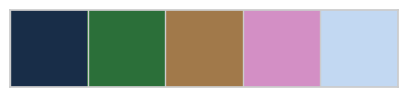

In [42]:
sns.set_style("whitegrid")
sns.palplot(sns.color_palette("cubehelix", 5))
sns.set_palette("cubehelix",5)

<Axes: xlabel='Gamma', ylabel='Accuracy'>

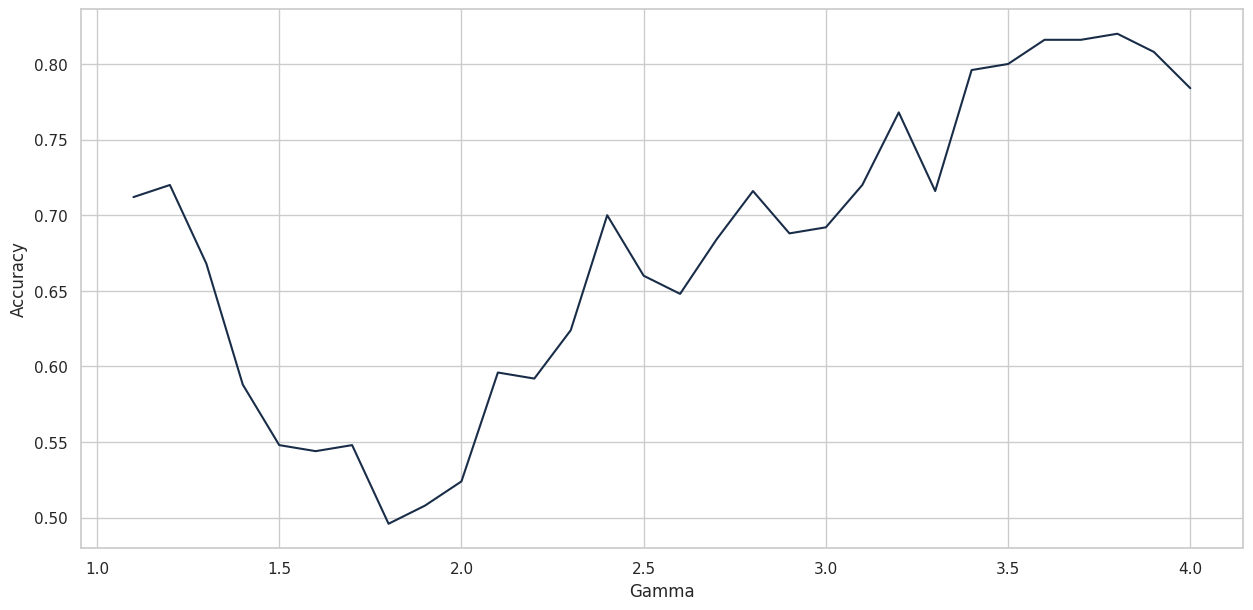

In [43]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set(xlabel='Gamma', ylabel='Accuracy')
sns.lineplot(ax=ax,x=gammas,y=numScores)
#ax = sns.lineplot(x=gammas, y=numScores)


<Axes: xlabel='Gamma', ylabel='Number of False Negatives'>

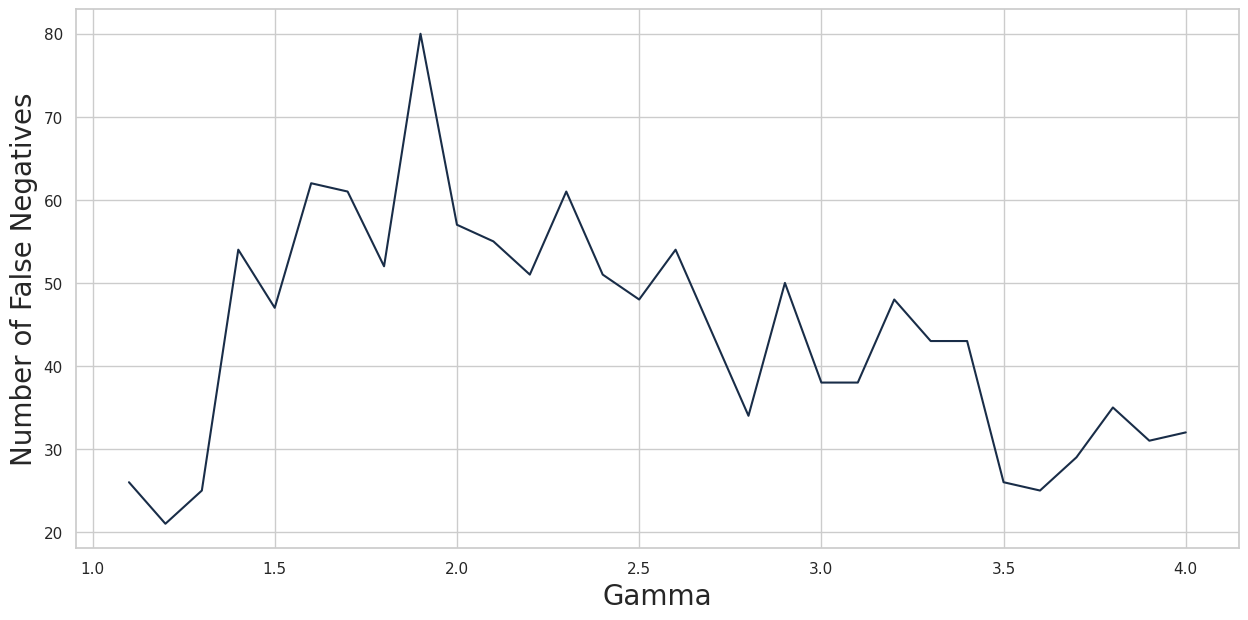

In [44]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_xlabel('Gamma',fontsize=20);
ax.set_ylabel('Number of False Negatives',fontsize=20);
#ax.set(xlabel='Gamma', ylabel='False Positives')
sns.lineplot(ax=ax,x=gammas,y=fns,markers=True)
#ax = sns.lineplot(x=gammas, y=numScores)


In [45]:
fpRatio = []
for i in range(len(fns)):
  fpRatio.append(fns[i]/totals[i])

<Axes: xlabel='Gamma', ylabel='False Negatives / Total Data Points'>

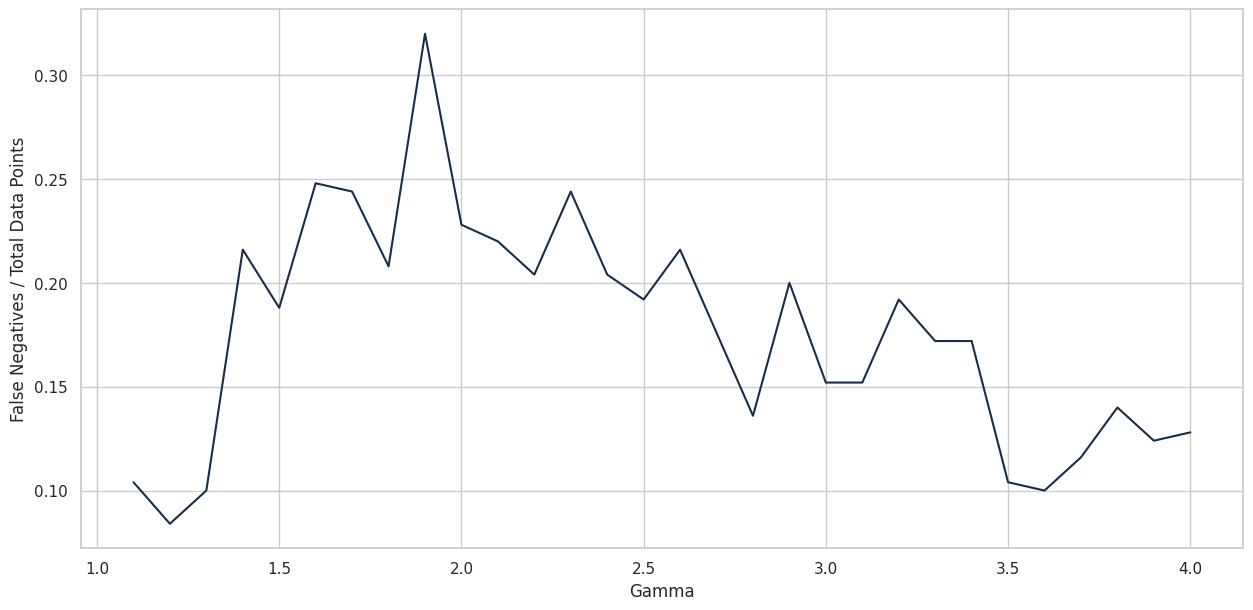

In [46]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set(xlabel='Gamma', ylabel='False Negatives / Total Data Points')
sns.lineplot(ax=ax,x=gammas,y=fpRatio)


In [47]:
d = {"gamma":gammas,"score":numScores,"fn":fns}
nDF = pd.DataFrame(data=d)

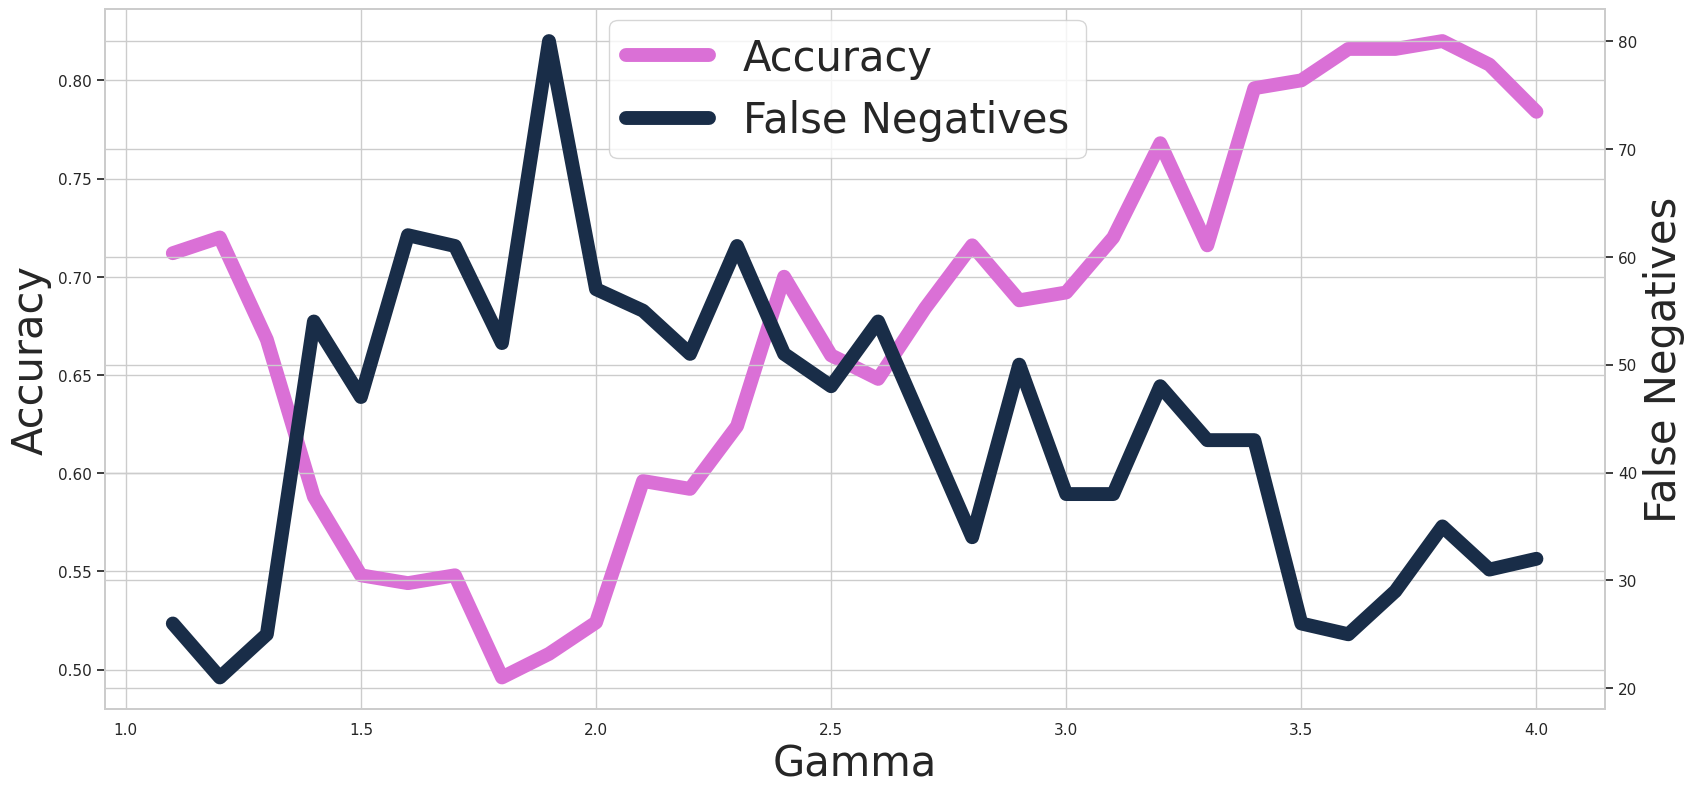

In [48]:
a4_dims = (15, 7)

fig = plt.figure(figsize=a4_dims)
a1 = fig.add_axes([0,0,1,1])
a1.plot(nDF["gamma"],nDF["score"],color="orchid",marker="x",linewidth=10.0)
a1.set_ylabel('Accuracy',fontsize = 30)
a1.set_xlabel("Gamma",fontsize = 30)
a2 = a1.twinx()
a2.plot(nDF["gamma"],nDF["fn"],marker="s",linewidth=10.0)
a2.set_ylabel('False Negatives',fontsize = 30)
a2.set_xlabel("Gamma",fontsize = 30)
fig.legend(labels = ('Accuracy','False Negatives'),loc='upper center',prop={'size': 30})
plt.show()

In [49]:
#Iterpolation attempt
import scipy.interpolate


In [50]:
f1 = interp1d(nDF["gamma"], nDF['score'],kind='cubic')
f2 = interp1d(nDF["gamma"], nDF['fn'],kind='cubic')
xnew = np.arange(1.1,4,.2)
df2 = pd.DataFrame()
df2['score'] = f1(xnew)
df2['fn'] = f2(xnew)
df2["xnew"] = xnew
a4_dims = (15, 7)

fig = plt.figure(figsize=a4_dims)
a1 = fig.add_axes([0,0,1,1])
a1.plot(df2["xnew"],df2["score"],color="red",linewidth=2.0)
a1.set_ylabel('Accuracy',fontsize = 30)
a1.set_xlabel("Gamma",fontsize = 30)
a2 = a1.twinx()
a2.plot(df2["xnew"],df2["fn"],linewidth=2.0)
a2.set_ylabel('False Negatives',fontsize = 30)
a2.set_xlabel("Gamma",fontsize = 30)
fig.legend(labels = ('Accuracy','False Negatives'),loc='best',prop={'size': 20})
plt.show()

NameError: name 'interp1d' is not defined

In [ ]:
x_new = np.linspace(1, 4, 300)
a_BSpline = interpolate.make_interp_spline(x, y)
y_new = a_BSpline(x_new)

In [ ]:
f1 = interp1d(nDF["gamma"], nDF['score'],kind='cubic')
f2 = interp1d(nDF["gamma"], nDF['fn'],kind='cubic')

xnew = np.arange(1.1,4,.3)
df2 = pd.DataFrame()
df2['Weight_A'] = f1(xnew)
#df2['Weight_B'] = f2(xnew)
print(df2)
ax2 = df2.plot.line()
ax2.set_title('After interpolation')
ax2.set_xlabel("year")
ax2.set_ylabel("weight")


plt.show()

In [ ]:
d = {"Logistic Regression":lrFNs,"Random Forest":rfFNs,"K Nearest Neighbor":knnFNs,"Multi-Layer Perceptron":mlpFNs,"Support Vector Classification":svmFNs,"gamma":gammas}
#n = np.array([lrFNs,rfFNs,knnFNs,mlpFNs,svmFNs])
mlstuffs = pd.DataFrame(d)

In [ ]:
print(svmScores)

In [ ]:
s = {"Logistic Regression":lrScores,"Random Forest":rfScores,"K Nearest Neighbor":knnScores,"Multi-Layer Perceptron":mlpScores,"Support Vector Classification":svmScores,"gamma":gammas}
scoreStuffs = pd.DataFrame(s)

In [ ]:
meltedScores = scoreStuffs.melt(id_vars=['gamma'])
meltedScores = scoreStuffs.melt(id_vars=['gamma'])
meltedScores.columns = ["gamma","Classification Model","Accuracy"]

In [ ]:
meltedML = mlstuffs.melt(id_vars=['gamma'])
meltedML.columns = ["gamma","Classification Model","Number of False Negatives"]

In [ ]:
from google.colab import drive
drive.mount('drive')

In [ ]:
meltedScores.to_csv('meltedScores.csv')
meltedML.to_csv("meltedML.csv")
!cp meltedScores.csv "drive/My Drive/Research"
!cp meltedML.csv "drive/My Drive/Research"

In [ ]:
meltedML.head()

In [ ]:
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
#ax.set(xlabel='Gamma', ylabel='False Negatives')
ax.set_xlabel('Gamma',fontsize=20);
ax.set_ylabel('Number of False Negatives',fontsize=20);
sns.lineplot(ax=ax,x="gamma",y="Number of False Negatives",hue="Classification Model",data=meltedML)
#this displays during trainig and testing "how many malicious messages made it through" at different gammas

In [ ]:
#plt.plot(meltedML[meltedML["Classification Model"] == "Logistic Regression"])
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
#ax.set(xlabel='Gamma', ylabel='False Negatives')
ax.set_xlabel('Gamma',fontsize=30);
ax.set_ylabel('Number of False Negatives',fontsize=30);
models = ["Logistic Regression","Random Forest","K Nearest Neighbor","Multi-Layer Perceptron","Support Vector Classification"]
markers = ["x","^","*","x","s"]
for i in range(len(models)):
  a = meltedML[meltedML["Classification Model"] == models[i]]
  if models[i] == "Multi-Layer Perceptron" or models[i] == "K Nearest Neighbor":
    plt.plot(a["gamma"],a["Number of False Negatives"],linewidth=10.0,marker=markers[i])
  else:
    plt.plot(a["gamma"],a["Number of False Negatives"],linewidth=1.0,marker=markers[i])
plt.legend(models,prop={'size': 20})

#lr = meltedML[meltedML["Classification Model"] == "Logistic Regression"]
#rf = meltedML[meltedML["Classification Model"] == "Random Forest"]

#plt.plot(lr["gamma"],lr["Number of False Negatives"])
#plt.plot(rf["gamma"],rf["Number of False Negatives"])


In [ ]:
meltedScores.head()

In [ ]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
#ax.set(xlabel='Gamma', ylabel='False Negatives')
ax.set_xlabel('Gamma',fontsize=20);
ax.set_ylabel('Accuracy',fontsize=20);
sns.lineplot(ax=ax,x="gamma",y="Accuracy",hue="Classification Model",data=meltedScores)
#this displays during trainig and testing "how many malicious messages made it through" at different gammas

In [ ]:
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_xlabel('Gamma',fontsize=30);
ax.set_ylabel('Accuracy',fontsize=30);
models = ["Logistic Regression","Random Forest","K Nearest Neighbor","Multi-Layer Perceptron","Support Vector Classification"]
markers = ["x","^","*","x","s"]
for i in range(len(models)):
  a = meltedScores[meltedScores["Classification Model"] == models[i]]
  if models[i] == "Multi-Layer Perceptron" or models[i] == "Support Vector Classification":
    plt.plot(a["gamma"],a["Accuracy"],linewidth=10.0,marker=markers[i])
  else:
    plt.plot(a["gamma"],a["Accuracy"],linewidth=1.0,marker=markers[i])
plt.legend(models,prop={'size': 20})

#lr = meltedML[meltedML["Classification Model"] == "Logistic Regression"]
#rf = meltedML[meltedML["Classification Model"] == "Random Forest"]

#plt.plot(lr["gamma"],lr["Number of False Negatives"])
#plt.plot(rf["gamma"],rf["Number of False Negatives"])


# Attempted Test

In [ ]:
ogData = addLabel(makeSentence(df),0)

In [ ]:
testData = pd.concat([ogData,malDF])

In [ ]:
testData

In [ ]:
testData[testData[1] == 1]

In [ ]:
tokenized = testData[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
padded

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(padded, testData[1], random_state=42)

In [ ]:
test_labels.value_counts()

### Logistic Regression Test

In [ ]:
lr_clf = LogisticRegression(max_iter=500)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))
y_pred = lr_clf.predict(test_features)

In [ ]:
confusion_matrix(test_labels, y_pred)

### Random Forest Test

In [ ]:
RandForest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RandForest.fit(train_features, train_labels)
forest_pred = RandForest.predict(test_features)
print(RandForest.score(test_features,test_labels))

In [ ]:
confusion_matrix(test_labels, forest_pred)

### KNN

In [ ]:
correct = []
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_features,train_labels)
    prediction = knn.predict(test_features)
    correct.append(np.mean(prediction == test_labels))

    plt.figure(figsize=(10, 5))
plt.plot(range(1, 20), correct)
plt.title('% Correct vs. K Value')
plt.xlabel('K Value')
plt.ylabel('% Correct')


#K Nearest Neighbor With Optimal Neighbor (1)
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(train_features,train_labels)
print("Accuracy " + str(knn.score(test_features, test_labels)))
y_pred = knn.predict(test_features)
print(confusion_matrix(test_labels, y_pred))
#print(classification_report(y_test, y_pred))

### Neural Networks

In [ ]:
NeuralNetwork = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
NeuralNetwork.fit(train_features, train_labels)
nn_pred = NeuralNetwork.predict(test_features)
print(NeuralNetwork.score(test_features,test_labels))
print(confusion_matrix(test_labels, nn_pred))

### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train_features,train_labels)

In [ ]:
pred = clf.predict(test_features)

In [ ]:
print(confusion_matrix(test_labels, pred))

### OCSVM